In [4]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import vnn
import torchvision
from imp import reload

In [5]:
reload(vnn)

def make_conv_net(mono):
    #torch.manual_seed(42)
    model = nn.Sequential(vnn.Conv2d(10, 30, 96*50, 5, stride=1, mono=mono, first_layer=True),
                          vnn.tReLU(),
                          vnn.Conv2d(10, 96*50, 96*50, 3, stride=1, mono=mono),
                          vnn.tReLU(),
                          vnn.Conv2d(10, 96*50, 96, 3, stride=2, mono=mono),
                          vnn.tReLU(),
                          vnn.Conv2d(10, 96, 96, 3, stride=2, mono=mono),
                          vnn.tReLU(),
                          vnn.Flatten(),
                          vnn.Linear(10, 2400, 1200, mono=mono),
                          vnn.tReLU(),
                          vnn.Linear(10, 1200, 600, mono=mono),
                          vnn.tReLU(),
                          vnn.Linear(10, 600, 1, mono=mono)).to(0)
    return model

def make_conv_input():
    #torch.manual_seed(42)
    data = torch.randn(1, 3, 32, 32)
    input = vnn.expand_input_conv(data, 10).to(0)
    return input

In [6]:
reload(vnn)

def make_fc_net(mono):
    #torch.manual_seed(42)
    model = nn.Sequential(vnn.Linear(10, 7840, 200, mono=mono, first_layer=True),
                          vnn.tReLU(),
                          vnn.Linear(10, 200, 200, mono=mono),
                          vnn.tReLU(),
                          vnn.Linear(10, 200, 200, mono=mono),
                          vnn.tReLU(),
                          vnn.Linear(10, 200, 200, mono=mono),
                          vnn.tReLU(),
                          vnn.Linear(10, 200, 200, mono=mono),
                          vnn.tReLU(),
                          vnn.Linear(10, 200, 1, mono=mono)).to(0)
    return model

def make_fc_input():
    #torch.manual_seed(42)
    data = torch.randn(1, 784)
    input = vnn.expand_input(data, 10).to(0)
    return input

In [7]:
conv_input = make_conv_input()
conv_mono = make_conv_net(mono=True)
conv_mono_out = conv_mono(conv_input).detach().cpu().numpy()
conv = make_conv_net(mono=False)
conv_out = conv(conv_input).detach().cpu().numpy()

fc_input = make_fc_input()
fc_mono = make_fc_net(mono=True)
fc_mono_out = fc_mono(fc_input).detach().cpu().numpy()
fc = make_fc_net(mono=False)
fc_out = fc(fc_input).detach().cpu().numpy()

Instantiated t with shape (10, 4800, 28, 28)
Instantiated t with shape (10, 4800, 26, 26)
Instantiated t with shape (10, 96, 12, 12)
Instantiated t with shape (10, 96, 5, 5)
Instantiated t with shape (10, 1200)
Instantiated t with shape (10, 600)
Instantiated t with shape (10, 4800, 28, 28)
Instantiated t with shape (10, 4800, 26, 26)
Instantiated t with shape (10, 96, 12, 12)
Instantiated t with shape (10, 96, 5, 5)
Instantiated t with shape (10, 1200)
Instantiated t with shape (10, 600)
Instantiated t with shape (10, 200)
Instantiated t with shape (10, 200)
Instantiated t with shape (10, 200)
Instantiated t with shape (10, 200)
Instantiated t with shape (10, 200)
Instantiated t with shape (10, 200)
Instantiated t with shape (10, 200)
Instantiated t with shape (10, 200)
Instantiated t with shape (10, 200)
Instantiated t with shape (10, 200)


In [8]:
fc_mono_out.std()

0.69794166

Text(0.5, 0, 'output value')

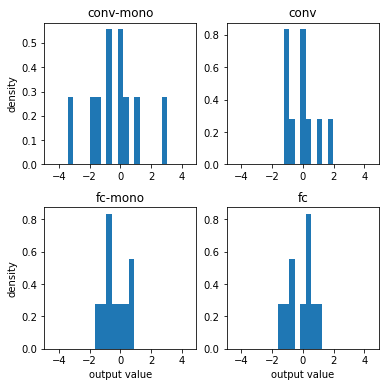

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6))
fig.subplots_adjust(hspace=0.3)
ax1, ax2, ax3, ax4 = axes.flatten()

rng = (-4.5, 4.5)
ax1.hist(conv_mono_out.flatten(), bins=25, density=True, range=rng)
ax2.hist(conv_out.flatten(), bins=25, density=True, range=rng)
ax3.hist(fc_mono_out.flatten(), bins=25, density=True, range=rng)
ax4.hist(fc_out.flatten(), bins=25, density=True, range=rng)

ax1.set_title("conv-mono")
ax2.set_title("conv")
ax3.set_title("fc-mono")
ax4.set_title("fc")

ax1.set_ylabel("density")
ax3.set_ylabel("density")

ax3.set_xlabel("output value")
ax4.set_xlabel("output value")

#plt.savefig("figs/inits.pdf", bbox_inches="tight")

In [10]:
labels = torch.randint(0, 10, (1,))
def compare_grads(model, input, layer_idx):
    opt = optim.SGD(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss(reduction="mean")
    
    out = model(input)[..., 0]
    loss = loss_fn(out, labels.to(0))

    opt.zero_grad()
    loss.backward()
    G1 = model[layer_idx].weight.grad.detach().cpu().numpy().flatten()

    opt.zero_grad()
    vnn.set_model_grads(model, out.detach(), labels.to(0))
    G2 = model[layer_idx].weight.grad.detach().cpu().numpy().flatten()
    
    return G1, G2

In [11]:
conv_input = make_conv_input()
conv = make_conv_net(mono=False)
conv_mono = make_conv_net(mono=True)

all_G_mono = [compare_grads(conv_mono, conv_input, i) for i in (0, 2, 4, 6, 9, 11)]
all_G = [compare_grads(conv, conv_input, i) for i in (0, 2, 4, 6, 9, 11)]

Instantiated t with shape (10, 4800, 28, 28)
Instantiated t with shape (10, 4800, 26, 26)
Instantiated t with shape (10, 96, 12, 12)
Instantiated t with shape (10, 96, 5, 5)
Instantiated t with shape (10, 1200)
Instantiated t with shape (10, 600)
0 get mask
2 get mask
4 get mask
6 get mask
9 get mask
11 get mask
0 get mask
2 get mask
4 get mask
6 get mask
9 get mask
11 get mask
0 get mask
2 get mask
4 get mask
6 get mask
9 get mask
11 get mask
0 get mask
2 get mask
4 get mask
6 get mask
9 get mask
11 get mask
0 get mask
2 get mask
4 get mask
6 get mask
9 get mask
11 get mask
0 get mask
2 get mask
4 get mask
6 get mask
9 get mask
11 get mask
Instantiated t with shape (10, 4800, 28, 28)
Instantiated t with shape (10, 4800, 26, 26)
Instantiated t with shape (10, 96, 12, 12)
Instantiated t with shape (10, 96, 5, 5)
Instantiated t with shape (10, 1200)
Instantiated t with shape (10, 600)
0 get mask
2 get mask
4 get mask
6 get mask
9 get mask
11 get mask
0 get mask
2 get mask
4 get mask
6 ge

In [12]:
from scipy.stats import pearsonr
def plot_conv_grad(all_G):
    fig, axes = plt.subplots(1, 6, figsize=(15, 2), dpi=120)
    fig.subplots_adjust(wspace=0.3)
    layers = np.arange(6) + 1
    for i in range(6):
        G1, G2 = all_G[i]
        axes[i].scatter(G1[::100], G2[::100], lw=0, s=1)
        axes[i].set_xlabel("gradient")
        axes[i].set_title("layer {} ({})".format(layers[i], ("conv" if i <= 2 else "fc")))
        print(np.rad2deg(np.arccos(pearsonr(G1, G2)[0])))
    axes[0].set_ylabel("global err. rule")

90.06659516002543
90.02857988536798
90.56687390896535
90.56478637413862
89.70826702419811
92.11364074915308


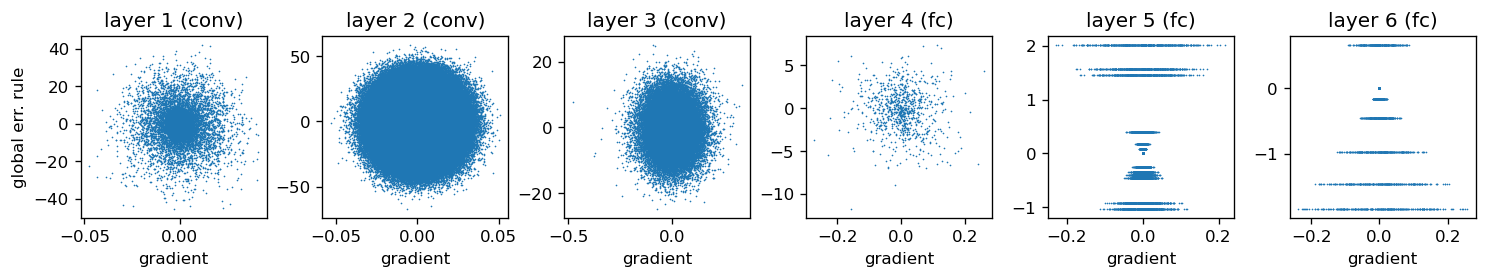

49.64953745219182
46.087897119420425
37.639728889420226
2.369994367131307
8.435481485496434
54.436441249771114


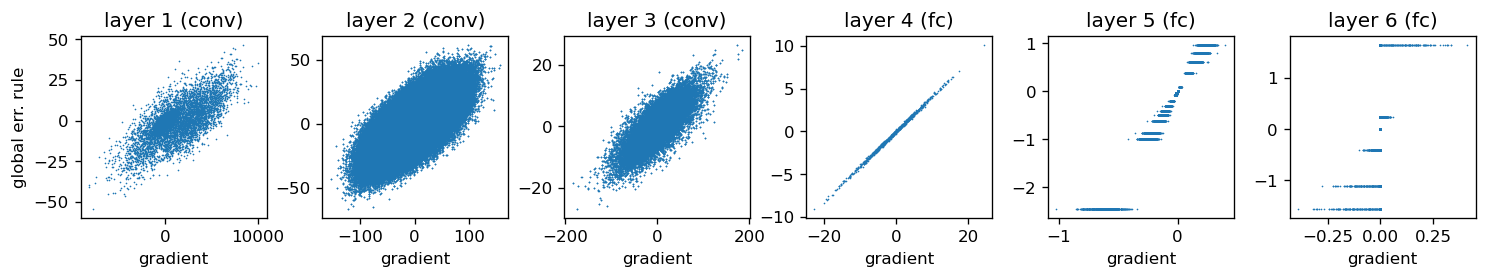

In [13]:
plot_conv_grad(all_G)
#plt.savefig("figs/grads_conv_mixed.png", bbox_inches="tight", dpi=300, facecolor="white")
plt.show()

plot_conv_grad(all_G_mono)
#plt.savefig("figs/grads_conv_mono.png", bbox_inches="tight", dpi=300, facecolor="white")
plt.show()

In [120]:
fc_input = make_fc_input()
fc = make_fc_net(mono=False)
fc_mono = make_fc_net(mono=True)

all_G_mono = [compare_grads(fc_mono, fc_input, i) for i in (0, 2, 4, 6, 8, 10)]
all_G = [compare_grads(fc, fc_input, i) for i in (0, 2, 4, 6, 8, 10)]

Instantiated t with shape (10, 200)
Instantiated t with shape (10, 200)
Instantiated t with shape (10, 200)
Instantiated t with shape (10, 200)
Instantiated t with shape (10, 200)
0 get mask
2 get mask
4 get mask
6 get mask
8 get mask
0 get mask
2 get mask
4 get mask
6 get mask
8 get mask
0 get mask
2 get mask
4 get mask
6 get mask
8 get mask
0 get mask
2 get mask
4 get mask
6 get mask
8 get mask
0 get mask
2 get mask
4 get mask
6 get mask
8 get mask
0 get mask
2 get mask
4 get mask
6 get mask
8 get mask
Instantiated t with shape (10, 200)
Instantiated t with shape (10, 200)
Instantiated t with shape (10, 200)
Instantiated t with shape (10, 200)
Instantiated t with shape (10, 200)
0 get mask
2 get mask
4 get mask
6 get mask
8 get mask
0 get mask
2 get mask
4 get mask
6 get mask
8 get mask
0 get mask
2 get mask
4 get mask
6 get mask
8 get mask
0 get mask
2 get mask
4 get mask
6 get mask
8 get mask
0 get mask
2 get mask
4 get mask
6 get mask
8 get mask
0 get mask
2 get mask
4 get mask
6 

In [121]:
def plot_fc_grad(all_G):
    fig, axes = plt.subplots(1, 6, figsize=(15, 2), dpi=120)
    fig.subplots_adjust(wspace=0.3)
    layers = np.arange(6) + 1
    for i in range(6):
        G1, G2 = all_G[i]
        axes[i].scatter(G1, G2, lw=0, s=1)
        axes[i].set_xlabel("gradient")
        axes[i].set_title("layer {} (fc)".format(layers[i]))
    axes[0].set_ylabel("global err. rule")

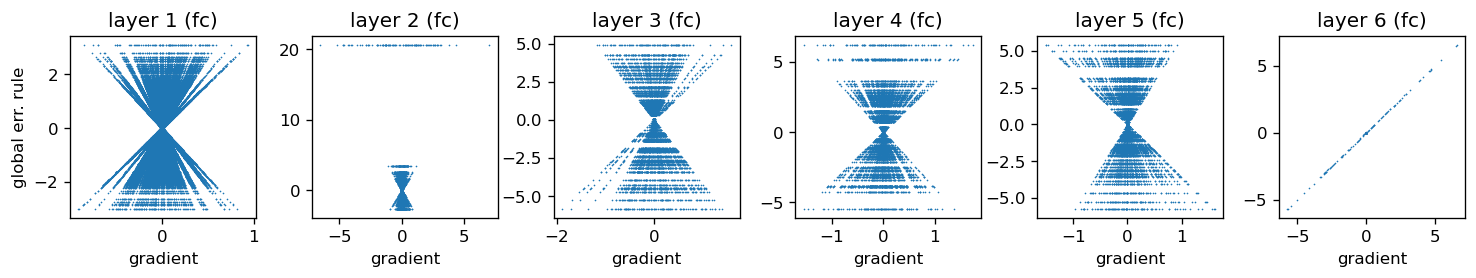

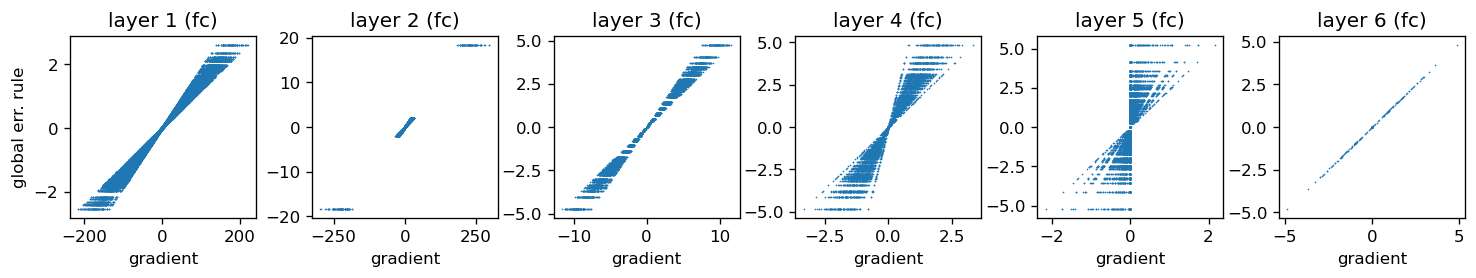

In [122]:
plot_fc_grad(all_G)
#plt.savefig("figs/grads_fc_mixed.png", bbox_inches="tight", dpi=300, facecolor="white")
plt.show()

plot_fc_grad(all_G_mono)
#plt.savefig("figs/grads_fc_mono.png", bbox_inches="tight", dpi=300, facecolor="white")
plt.show()

In [137]:
conv = vnn.Conv2d(10, 3, 5, 4, stride=1, mono=False)
W = torch.randn(5, 3, 4, 4)
b = torch.randn(10, 5)
with torch.no_grad():
    conv.conv.weight[:] = W
    conv.bias[:] = b

In [138]:
data = torch.randn(128, 10, 3, 32, 32)
out = conv(data)

In [139]:
out_2 = torch.zeros_like(out)
for i in range(10):
    out_2[:, i] = F.conv2d(data[:, i], weight=W, bias=b[i])

In [140]:
torch.max(torch.abs(out - out_2))

tensor(0., grad_fn=<MaxBackward1>)

In [84]:
W = torch.randn(1, 100)
W[::2].shape

torch.Size([1, 100])